# Video game sales analysis

TODO: Description

In [157]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML


sns.set(rc={"figure.figsize":(12,8)})
sns.set(style="white")

# Load data

In [2]:
zf = zipfile.ZipFile('../data/vgsales.csv.zip') 
df = pd.read_csv(zf.open('vgsales.csv'))

# Explore and prepare data

In [3]:
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [4]:
# Convert year column to int type

df['Year'] = df['Year'].astype('Int64')

In [5]:
# Percentage of NaN values on each column 

df.isnull().mean().sort_values(ascending=False).mul(100).round(2).astype(str) + '%'

Year            1.63%
Publisher       0.35%
Global_Sales     0.0%
Other_Sales      0.0%
JP_Sales         0.0%
EU_Sales         0.0%
NA_Sales         0.0%
Genre            0.0%
Platform         0.0%
Name             0.0%
Rank             0.0%
dtype: object

In [71]:
# Clean NaN values

df_no_nan = df.dropna(how="any")

# Clean years after 2016 (because de data was obtained in 2016)

df_clean = df_no_nan[df_no_nan['Year'] <= 2016].copy()

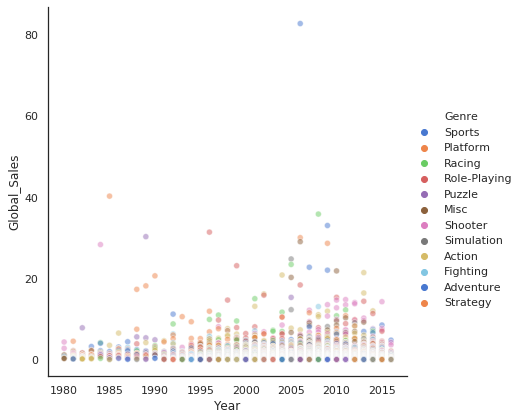

In [7]:
# Plot video game global sales per year (with genre information)

sns.relplot(x="Year", y="Global_Sales", hue="Genre", 
            alpha=.5, palette="muted",
            height=6, data=df_clean)

In [8]:
# Top 10 more selling games

df_clean[df_clean['Rank'] <= 10]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
5,6,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6,7,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
7,8,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02
8,9,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62
9,10,Duck Hunt,NES,1984,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


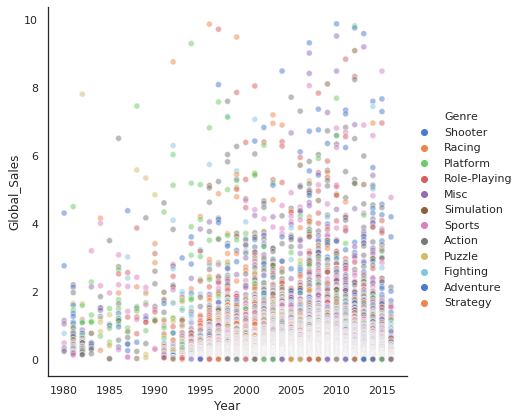

In [9]:
# Plot video game global sales per year (with genre information)
# just for video games that sold less than 10 million units

sns.relplot(x="Year", y="Global_Sales", hue="Genre", 
            alpha=.5, palette="muted",
            height=6, data=df_clean[df_clean['Global_Sales'] <= 10])

# Analysis

## Question 1 - What is the most successful video game console in history?

we consider the most successful the one for which more video game units have been sold (in millions of units)

In [10]:
# Absolute values of more succesful platforms (in terms of games unit sold)

df_clean.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False).head(10)

Platform
PS2     1233.46
X360     969.60
PS3      949.35
Wii      909.81
DS       818.62
PS       727.39
GBA      305.62
PSP      291.71
PS4      278.07
PC       254.70
Name: Global_Sales, dtype: float64

### Historical evolution

In [11]:
# Grouped by platform and accumulating global sales for each year

df_plt = df_clean.groupby(['Platform', 'Year']).sum()['Global_Sales'].reset_index()
df_plt

,Platform,Year,Global_Sales
0,2600,1980,11.38
1,2600,1981,35.77
2,2600,1982,28.86
3,2600,1983,5.83
4,2600,1984,0.27
...,...,...,...
233,XB,2008,0.18
234,XOne,2013,18.60
235,XOne,2014,52.43
236,XOne,2015,57.66


In [12]:
# To be able to acummulate total global sales for a platform we need to fill missing year (years with no sales)
# with a global sale of 0. The way of doing that it's with a datetime index

df_plt['Year'] = pd.to_datetime(df_plt['Year'], format='%Y')
df_plt_di = df_plt.set_index('Year')

# create a row for each platform with information of the last year of the dataset (2017)

max_date = df_plt_di.index.max()
platforms_in_last_year_list = list(df_plt_di.loc[max_date, 'Platform'].unique())
platforms_not_in_last_year_list = list(set(df_plt_di['Platform'].unique()) \
                                           .difference(platforms_in_last_year_list))
platforms_not_in_last_year_df = pd.DataFrame({'Year': max_date, 
                                              'Platform': platforms_not_in_last_year_list, 
                                              'Global_Sales': 0}).set_index('Year')

# resample and bfill to include all missing years (until last year) with sales 0
# and reindex to lost datetime index (not necessary anymore)

df_plt_di_complete = pd.concat([df_plt_di, platforms_not_in_last_year_df]) \
                       .groupby('Platform').resample('AS')['Global_Sales'] \
                       .bfill().reset_index()
df_plt_di_complete['Year'] = df_plt_di_complete['Year'].dt.year

# Add a column with cumulate sum of global sales

df_plt_di_complete['Global_Sales_Cumsum']= df_plt_di_complete \
                                           .groupby('Platform')['Global_Sales'] \
                                           .transform(pd.Series.cumsum) 

In [13]:
# Add family for each platform

families = {'Wii' : 'Nintendo', 
            'NES' : 'Nintendo',  
            'GB' : 'Nintendo',
            'DS' : 'Nintendo',
            'X360' : 'Microsoft',
            'PS3' : 'Sony',
            'PS2' : 'Sony',
            'SNES' : 'Nintendo',
            'GBA' : 'Nintendo',
            '3DS' : 'Nintendo',
            'PS4' : 'Sony',
            'N64' : 'Nintendo',
            'PS' : 'Sony',
            'XB' : 'Microsoft',
            'PC' : 'Microsoft',
            '2600' : 'Atari',
            'PSP' : 'Sony',
            'XOne' : 'Microsoft',
            'GC' : 'Nintendo',
            'WiiU' : 'Nintendo',
            'GEN' : 'Sega',
            'DC' : 'Sega',
            'PSV' : 'Sony',
            'SAT' : 'Sega',
            'SCD' : 'Sega',
            'WS' : 'Bandai',
            'NG' : 'SNK',
            'TG16' : 'NEC',
            '3DO' : 'Panasonic',
            'GG' : 'Sega',
            'PCFX' : 'NEC'
           }

df_plt_di_complete['Family'] = df_plt_di_complete['Platform'].map(families)

In [14]:
# Function to calculate the top of one year

def top_of_year(df, year, top_number=8):
    """Return a dataframe with the top videogames of a given year 
    (top considering accumulate global sales up to that year)

    Parameters:
    df (DataFrame): Dataframe with unit solds for all platforms
    year (int): Year to calculate the top
    top_number (int): Number of rows

    Returns:
    DataFrame: Dataframe with the top

   """
    df = df[df['Year'].eq(year)].sort_values(by='Global_Sales_Cumsum', ascending=True)
    df = df[['Platform', 'Family', 'Global_Sales_Cumsum']]
    row_count = df.shape[0]
    if row_count >= top_number:
        return df.tail(top_number).reset_index(drop=True)
    else:
        df_empty_rows = pd.DataFrame(columns=['Platform', 'Global_Sales_Cumsum', 'Family'])
        for i in range(row_count, top_number):
            df_empty_rows = df_empty_rows.append({'Platform': '-' * (i - row_count + 1), 'Global_Sales_Cumsum': 0, 'Family': 'None'}, ignore_index=True)
        return pd.concat([df_empty_rows, df]).reset_index(drop=True)

In [15]:
# Example of use: Top 5 for 1995

dff = top_of_year(df_plt_di_complete, 1995, 5)
dff

,Platform,Family,Global_Sales_Cumsum
0,2600,Atari,86.57
1,GB,Nintendo,130.29
2,DS,Nintendo,174.62
3,SNES,Nintendo,182.65
4,NES,Nintendo,251.07


In [16]:
# Assign a different color for each family

colors = dict(zip( 
    ["Atari",   "Panasonic", "Nintendo", "Sega",    "SNK",     "Microsoft", "NEC",     "Sony",    "Bandai", "None"],
    ["#c3bc3f", "#bb7693",   "#ef6f6a",  "#8cc2ca", "#767676", "#55ad89",   "#a9b5ae", "#6388b4", "#baa094", "#ffffff"]
))

In [17]:
# Function to draw one year

def draw_barchart(year, top_number=8):
    dff = top_of_year(df_plt_di_complete, year, top_number)
    ax.clear()
    ax.barh(dff['Platform'], dff['Global_Sales_Cumsum'], color=[colors[x] for x in dff['Family']])
    dx = dff['Global_Sales_Cumsum'].max() / 200
    for i, (value, name, group) in enumerate(zip(dff['Global_Sales_Cumsum'], dff['Platform'], dff['Family'])):
        if value > 0:
            ax.text(value-dx, i,     name,            size=14, weight=600, ha='right', va='bottom')
            ax.text(value-dx, i-.25, group,           size=10, color='#444444', ha='right', va='baseline')
            ax.text(value+dx, i,     f'{value:,.0f}', size=14, ha='left',  va='center')
    ax.text(1, 0.4, year, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Video game units sold (millions)', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.15, 'The most successful video game platform from 1980 to 2016',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    ax.text(1, 0, 'by @tomasborrella; credit @pratapvardhan', transform=ax.transAxes, color='#777777', ha='right',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)

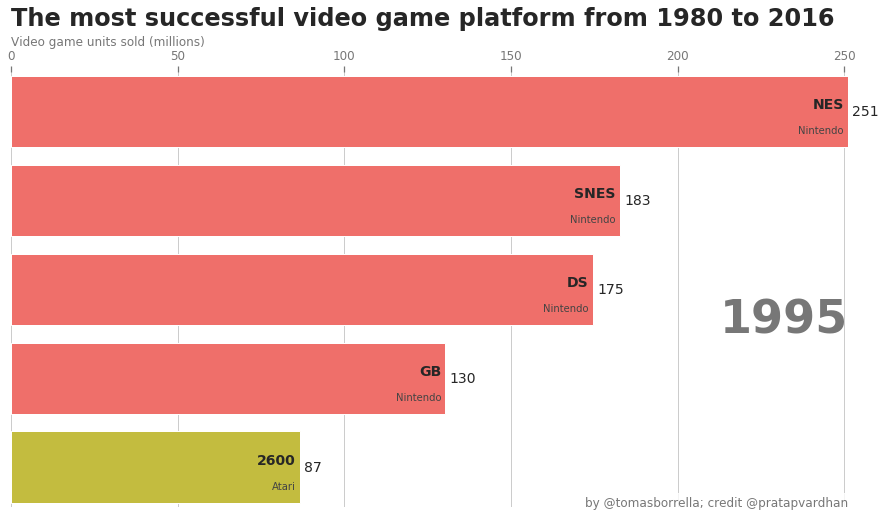

In [18]:
# Example of use: Top 5 for 1995

fig, ax = plt.subplots(figsize=(15, 8))
draw_barchart(1995, 5)

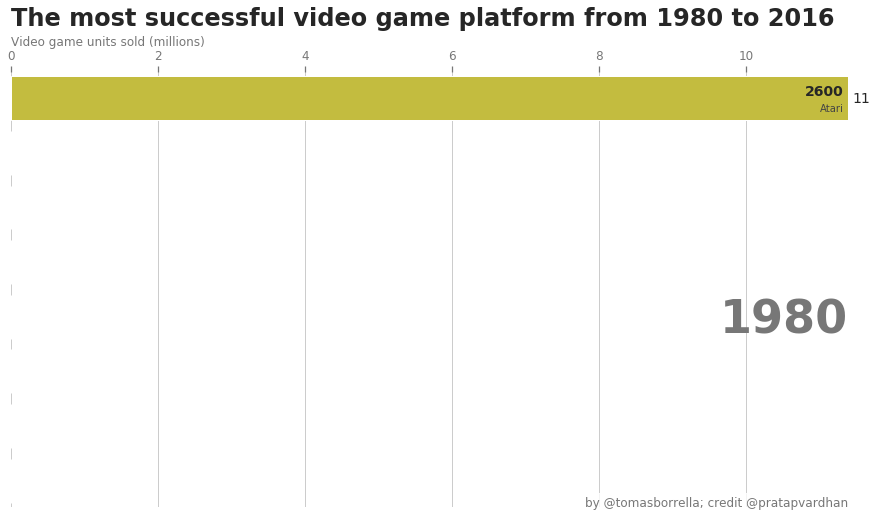

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1980, 2017), interval=1000)
HTML(animator.to_jshtml())
# or use animator.to_html5_video()

# to create a gif of the animation:
# 1. Save with :
#    animator.save('animation.mp4', clear_temp=False)
#    or
#    animator.save("../images/animation.png", writer="imagemagick")
# 2. Convert png files to gif with:
#    convert -delay 30 *.png animation.gif
# note: packages ffmpeg:i386 and x264 could be needed in your system

## Question 2 - Is there a growing trend in the video game market?

In [28]:
df_global_sales_per_year = df_clean.groupby('Year')['Global_Sales'].sum().reset_index()

# Remove 2016 because the year is not complete 

df_global_sales_per_year = df_global_sales_per_year[df_global_sales_per_year['Year'] < 2016]

In [34]:
# dataframe with maximum to be able to plot the point

maximum = df_global_sales_per_year['Global_Sales'].abs().max()
df_global_sales_per_year['max'] = df_global_sales_per_year['Global_Sales'].apply(lambda x: np.nan if x < maximum else maximum)
df_max = df_global_sales_per_year.loc[df_global_sales_per_year['max'] == df_global_sales_per_year['max'].max(),['Year', 'Global_Sales']]

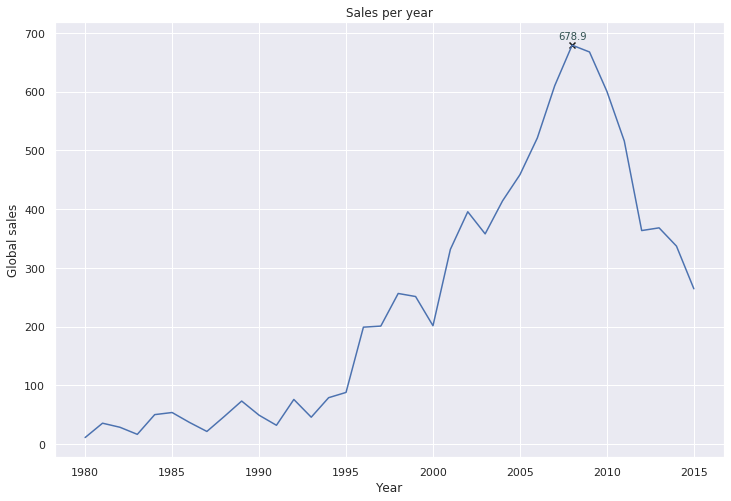

In [51]:
# plot using lineplot

fig, ax = plt.subplots()

sns.lineplot(data=df_global_sales_per_year, x='Year', y='Global_Sales', ci=None, ax=ax)

ax.scatter(df_max.iloc[0]['Year'], 
           df_max.iloc[0]['Global_Sales'], 
           c='k', 
           marker='x')
ax.text(df_max.iloc[0]['Year'], 
        df_max.iloc[0]['Global_Sales'] + 10,
        str(round(df_max.iloc[0]['Global_Sales'],3)),
        ha='center',
        size=10,
        color='#2F4F4F')

ax.set(xlabel="Year", ylabel="Global sales", title="Sales per year");

## Question 3 - What is the most successful video game genre in each decade? Have gamers' tastes changed over time?

In [72]:
df_clean['Decade'] = ((np.floor(df_clean['Year'] / 10) * 10).astype(int))
df_clean

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Decade
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,2000
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,1980
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,2000
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,2000
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,1990
...,...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002,Platform,Kemco,0.01,0.00,0.00,0.00,0.01,2000
16594,16597,Men in Black II: Alien Escape,GC,2003,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01,2000
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,Activision,0.00,0.00,0.00,0.00,0.01,2000
16596,16599,Know How 2,DS,2010,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01,2010


In [95]:
df_clean_grouped = (df_clean
                    .groupby(['Genre', 'Decade'])
                    .Global_Sales
                    .sum()
                    .reset_index())

In [107]:
df_clean_grouped['Decade_Global_Sales'] = df_clean_grouped.groupby('Decade').Global_Sales.transform('sum')
df_clean_grouped['%Global_Sales'] = (df_clean_grouped['Global_Sales'] / df_clean_grouped['Decade_Global_Sales']).mul(100).round(2)
df_clean_grouped.head(10)

,Genre,Decade,Global_Sales,Decade_Global_Sales,%Global_Sales
0,Action,1980,51.18,376.58,13.59
1,Action,1990,139.29,1278.91,10.89
2,Action,2000,858.91,4636.08,18.53
3,Action,2010,673.45,2520.06,26.72
4,Adventure,1980,4.78,376.58,1.27
5,Adventure,1990,44.81,1278.91,3.50
6,Adventure,2000,123.97,4636.08,2.67
7,Adventure,2010,61.03,2520.06,2.42
8,Fighting,1980,7.24,376.58,1.92
9,Fighting,1990,123.45,1278.91,9.65


In [108]:
df_clean_grouped[["Genre", "Decade","%Global_Sales"]].head(10)

,Genre,Decade,%Global_Sales
0,Action,1980,13.59
1,Action,1990,10.89
2,Action,2000,18.53
3,Action,2010,26.72
4,Adventure,1980,1.27
5,Adventure,1990,3.50
6,Adventure,2000,2.67
7,Adventure,2010,2.42
8,Fighting,1980,1.92
9,Fighting,1990,9.65


In [151]:
# Get the 3 most popular genres in each decade
genres_set = set()
for i in [1980, 1990, 2000, 2010]:
    a, b, c = df_clean_grouped[df_clean_grouped['Decade'] == i].sort_values('%Global_Sales', ascending=False)['Genre'].head(3)
    genres_set.add(a)
    genres_set.add(b)
    genres_set.add(c)
genres_set

{'Action',
 'Misc',
 'Platform',
 'Puzzle',
 'Racing',
 'Role-Playing',
 'Shooter',
 'Sports'}

In [153]:
dff = df_clean_grouped[df_clean_grouped['Genre'].isin(genres_set)]

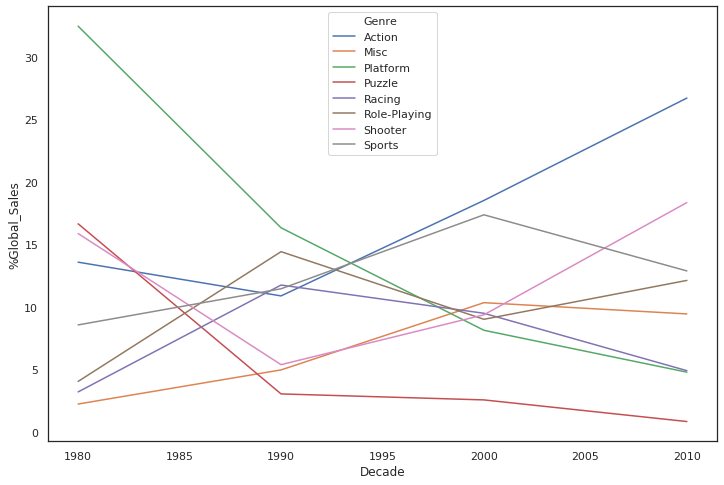

In [154]:
# plot using lineplot

fig, ax = plt.subplots()

sns.lineplot(data=dff, x='Decade', y='%Global_Sales', hue='Genre')

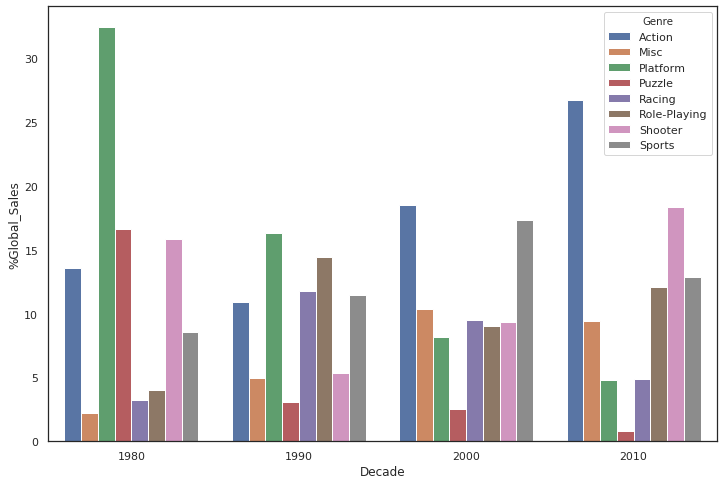

In [155]:
# plot barplot

fig, ax = plt.subplots()

sns.barplot(data=dff, x='Decade', y='%Global_Sales', hue='Genre')